In [35]:
import igl
import numpy as np
import networkx as nx
import drawSvg as draw
import meshplot as mp
mp.jupyter()

GAUSS_CURV_THRESHOLD = 1e-0
MIN_FACES = 10

def add_edges_from_mesh(graph, faces, is_cut_face):
    face_adjacency_matrix, _ = igl.triangle_triangle_adjacency(faces)
    for face_id, _ in enumerate(faces):
        for ajd_face_id in face_adjacency_matrix[face_id]:
            if ajd_face_id >= 0:
                if is_cut_face is None:
                    graph.add_edge(face_id,ajd_face_id)
                elif not (is_cut_face[face_id] == True and is_cut_face[ajd_face_id] == True):
                    graph.add_edge(face_id,ajd_face_id)

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(graph, faces): [graph.add_node(face_id) for face_id, face in enumerate(faces)]

# create networkx graph from given mesh
def graph_from_mesh(faces, is_cut_face=None):
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces, is_cut_face)
    return graph

# returns a rotation matrix from a (unnormalized) axis and an angle
def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

# returns a matrix that maps 3D space onto a 2D plane (the orientation of which is specified by 'face_normal').
def get_2d_projection(face_normal):
    xy_plane_normal = np.array([0,0,1])  # aka 'the z-axis'
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)


def draw_polygons(polygons):
    # generate svg visualization
    drawing = None
    drawing = draw.Drawing(1000, 1000, origin='center')
    for polygon in polygons:
        # polygon = [coords[0:2] for coords in polygon]
        drawing.append(draw.Lines(*np.array(polygon).flatten()*800,
                                  close=True, fill='#eeee00', stroke='#000', stroke_width=.1, fill_opacity=.5))

    drawing.rasterize()
    return drawing

def draw_polygon_groups(polygon_groups, scale=800):
    # generate svg visualization
    drawing = None
    drawing = draw.Drawing(1000, 1000, origin='center')
    palette = iter(['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0'])
    
    for polygons in polygon_groups:
        color = next(palette)
        for polygon in polygons:
            # polygon = [coords[0:2] for coords in polygon]
            drawing.append(draw.Lines(*np.array(polygon).flatten()*scale,
                                      close=True, fill=color, stroke='#000', stroke_width=.1, fill_opacity=.5))

    drawing.rasterize()
    return drawing

In [38]:
# load mesh
raw_vertices, raw_faces = igl.read_triangle_mesh("data/Sphericon.stl")
# raw_vertices, raw_faces = igl.read_triangle_mesh("data/CrumpledDevelopable.obj")
# raw_vertices, raw_faces = igl.read_triangle_mesh("data/coffee_thinned.obj")
# raw_vertices, raw_faces = igl.read_triangle_mesh("data/lilium_thinned.obj")
vertices, faces, _ = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)

number of vertices: 40 number of faces: 76
Graph with 76 nodes and 114 edges (original)
Graph with 76 nodes and 114 edges (developable)
Graph with 76 nodes and 114 edges (developable, isolates removed)

Number of faces in each piece: 
76


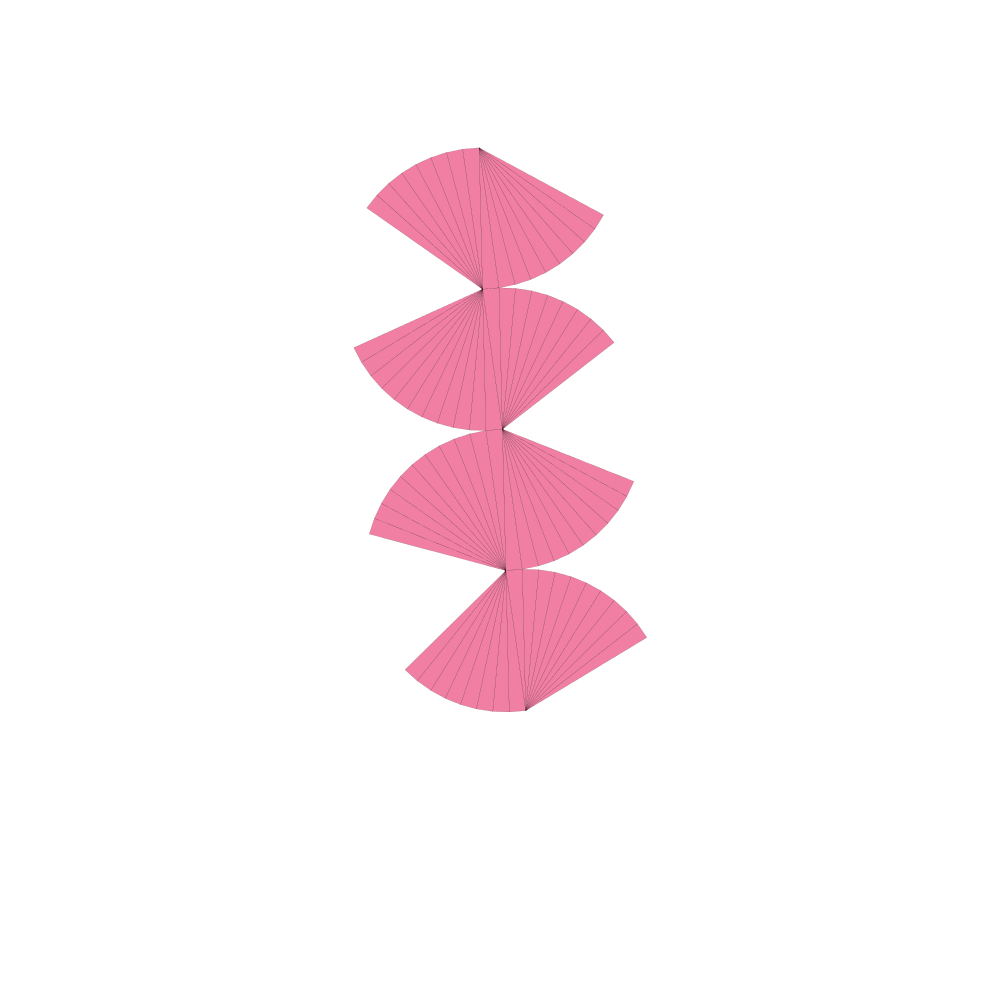

In [39]:
# find commone edge of two adjacent faces
def find_common_edge(faces, face_id_a, face_id_b):
    # make sure that the resulting vertex ids are clockwise wrt. source face
    face_vertex_array_a = faces[face_id_a]
    face_vertex_array_b = faces[face_id_b]

    for i in range(3):
        if face_vertex_array_a[i] in face_vertex_array_b and face_vertex_array_a[(i+1) % 3] in face_vertex_array_b:
            return (face_vertex_array_a[i], face_vertex_array_a[(i+1) % 3])

    return None

def get_face_normal(vertices, faces, face_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return face_normals[face_id]

# get angle between the normals of two faces
def dihedral_angle(vertices, faces, face_a_id, face_b_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return np.arccos(np.clip(np.dot(face_normals[face_a_id], face_normals[face_b_id]), -1.0, 1.0))

def unfold(vertices, faces):
    # Calculating the principal curvature and gassian curvature (on the vertices)
    v1, v2, k1, k2 = igl.principal_curvature(vertices, faces)
    gaussian_curv = k1 * k2
    # extract graph from vertices of non-zero gaussian curvature
    # those _edges_ should be ommited from the unfolding path
    
    cut_vertices = gaussian_curv > GAUSS_CURV_THRESHOLD
    is_cut_face = np.zeros(faces.shape[0], dtype=bool)
    
    
    for i in range(faces.shape[0]):
        if np.sum(cut_vertices[faces[i]]) >= 2:
            is_cut_face[i] = True
    
    print('number of vertices:', vertices.shape[0], 'number of faces:', faces.shape[0])
    print(graph_from_mesh(faces), '(original)')
    G = graph_from_mesh(faces, is_cut_face)
    print(G, '(developable)')
    G.remove_nodes_from(list(nx.isolates(G)))
    # G = graph_from_mesh(faces)
    print(G, '(developable, isolates removed)')

    
    polygon_groups = []  # resulting polygons, represented as lists of 2D coordinates

    parent_dict_list = []
    source_face_ids = []
    
    while len(G.nodes) > 0:
        source_face_id = list(G.nodes)[0]
        source_face_ids.append(source_face_id)
        # parent_dict = nx.dfs_predecessors(G, source=source_face_id)  # format { node_id: parent_id, ... }
        parent_list = list(nx.bfs_predecessors(G, source=source_face_id))
        parent_list.append((source_face_id, None))
        # print(parent_list)
        parent_dict = dict(parent_list)  # format { node_id: parent_id, ... }
        # parent_dict[source_face_id] = None  # add the source face, as networkX is not doing this by default
        parent_dict_list.append(parent_dict)
        
        for nodes in parent_list:
            G.remove_node(nodes[0])
        # print(G)
        # break
    
    iter_source_face = iter(source_face_ids)
    
    print('\n', '\bNumber of faces in each piece: ')
    for parent_dict in parent_dict_list:
        polygons = []  # resulting polygons, represented as lists of 2D coordinates
        source_face_id = next(iter_source_face)
        
        if len(parent_dict) < MIN_FACES: # threshold for minimum number of faces
            continue
        print(len(parent_dict))
        for face_id, parent_face_id in parent_dict.items():
            # retrieve the coordinates of current face
            face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_id]]
            
            # iterate over all parents and apply unfolding rotations accordingly
            selected_face_id = face_id
            selected_parent_face_id = parent_face_id
            
            while selected_face_id != source_face_id:
                # get edge between selected face and parent as tuple of two vertex_ids
                hinge_edge = find_common_edge(faces, selected_parent_face_id, selected_face_id)
                
                # apply unfolding transformation:
                # - all face_coordinates are offset such that the hinge_edge aligns with the origin
                # - then, the rotation around the hinge_edge is performed, such that the selected face
                #   and the parent lay in the same plane
                # - finally, we reverse the offset, such that the face ends up in its original position 
                offset = vertices[hinge_edge[0]]
                rotation_angle = dihedral_angle(
                    vertices, faces, selected_face_id, selected_parent_face_id)
                rotation_axis = vertices[hinge_edge[0]] - vertices[hinge_edge[1]]
                rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle)
    
                for i in range(3):
                    face_coordinates[i] = rotation_matrix.dot(face_coordinates[i] - offset) + offset
    
                # climbing up the tree
                selected_face_id = selected_parent_face_id
                selected_parent_face_id = parent_dict[selected_parent_face_id]
    
            # project 3D coordinates into the 2D plane that 
            for i in range(3):
                # print(get_2d_projection(get_face_normal(vertices, faces, source_face_id)), face_coordinates[i])
                face_coordinates[i] = get_2d_projection(get_face_normal(vertices, faces, source_face_id)).dot(face_coordinates[i])
                # print(face_coordinates[i])
                
            polygons.append(face_coordinates)
        
        polygon_groups.append(polygons)
    return polygon_groups

draw_polygon_groups(unfold(vertices, faces))

# # Buggy, does not show 
# polygon_groups = unfold(vertices, faces)
# palette = iter(['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0'])
# for polygons in polygon_groups:
#     color = next(palette)
#     draw_polygons(polygons)
#     print("break")
#     break

# TODO: fill gaps during unfolding

In [5]:
mp.plot(vertices, faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.266598…